In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from skimage import filters, color
from scipy.ndimage.filters import laplace
from utils import *

pictures_dir = "pictures"
setup = "room"

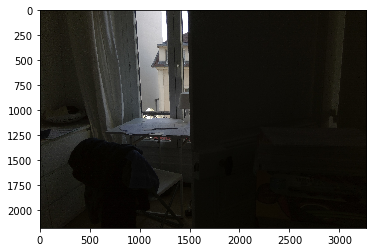

In [2]:
pic_path = os.path.join(pictures_dir, setup, "0.jpg")
im = Image.open(pic_path)
plt.imshow(np.asarray(im));

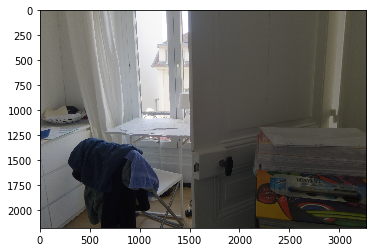

In [3]:
im = naive_average(load_images_from_path(pictures_dir, setup))
results_dir = "results"
output_path = os.path.join(results_dir, setup, "naive_merge.jpg")

if not os.path.exists(os.path.join(results_dir, setup)):
    os.mkdir(os.path.join(results_dir, setup ))

Image.fromarray(im).save(output_path)
plt.imshow(im);

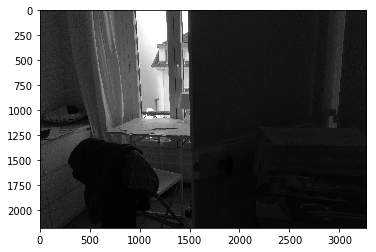

In [4]:
pic_path = os.path.join(pictures_dir, setup, "1.jpg")
im = Image.open(pic_path)
im = np.asarray(im).astype(float)
im_gray = color.rgb2gray(im)
plt.imshow(im_gray, cmap="gray");

### Contrast: 
we apply a Laplacian filter to the grayscale version of each image, and take the absolute value of the filter response [16]. This yields a simple indicator C for contrast. It tends to assign a high weight to important elements such as edges and texture. A similar measure was used for multi-focus fusion for extended depth-of-field [19].

l'image est assez sale si on passe pas de gaussien avant mais d'après la suite de l'article:
"We could avoid sharp weight map transitions by smoothing the weight map with a Gaussian filter, but this results in undesirable halos around edges, and spills information across object boundaries"

In [5]:
np.max(contrast(im_gray))

/anaconda3/lib/python3.6/site-packages/skimage/restoration/uft.py:447: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  impr[([slice(1, 2)] * ndim)] = 2.0 * ndim


420.70379999999994

In [6]:
np.median(contrast(im_gray))

3.9999999999999893

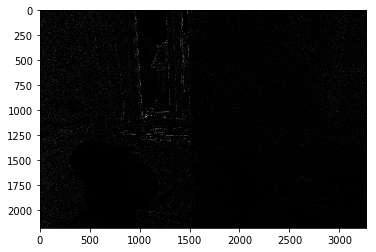

In [7]:
plt.imshow(normalize(contrast(im_gray)), cmap="gray");

### Saturation: 
As a photograph undergoes a longer exposure, the resulting colors become desaturated and eventually clipped. Saturated colors are desirable and make the image look vivid. We include a saturation measure S, which is computed as the standard deviation within the R, G and B channel, at each pixel.

la je capte pas trop. je pense que en chaque pixel on prend abs(f(x, couleur) - moyenne_globale(couleur)). et ensuite on additionne pour les 3 couleurs ?

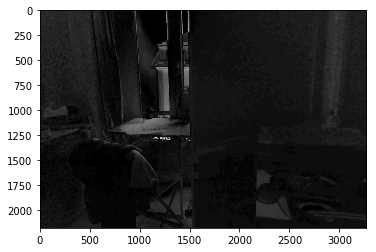

In [10]:
plt.imshow(normalize(saturation(im, version='new')), cmap="gray");

### Well-exposedness:
Looking at just the raw intensities within a channel, reveals how well a pixel is exposed.
We want to keep intensities that are not near zero (underexposed) or one (overexposed). We weight each intensity
i based on how close it is to 0.5 using a Gauss curve: exp 􀀀− (i−0.5)2
22 , where  equals 0.2 in our implementation.
To account for multiple color channels, we apply the Gauss curve to each channel separately, and multiply the results, yielding the measure E.

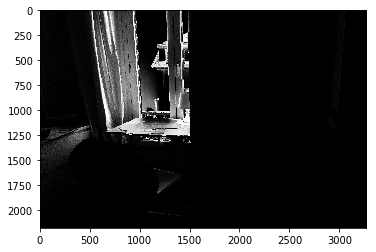

In [11]:
plt.imshow(normalize(exposure(im)), cmap="gray");

### Weigth Map:

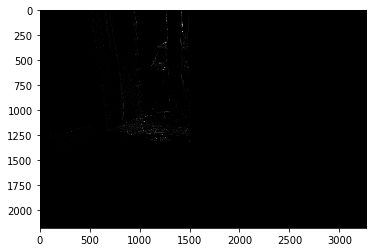

In [12]:
wm = weight_map(im, wc=1, we=1, ws=1)
plt.imshow(normalize(wm), cmap="gray");

count:  19995


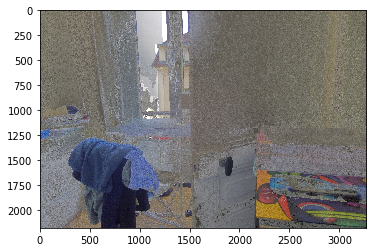

In [13]:
# cf figure 4.b dans le papier
images = load_images_from_path(pictures_dir, setup)
merged = eq1(images)
plt.imshow(merged);

count:  0


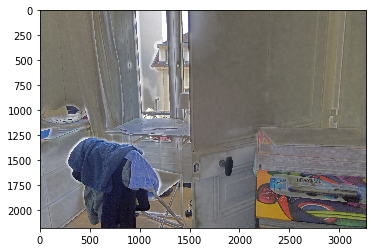

In [14]:
# cf figure 4.c dans le papier
images = load_images_from_path(pictures_dir, setup)
merged = eq1(images, blur=True, sigma=10.)
plt.imshow(merged);

In [15]:
del images
del merged
del wm
del im

### An edge-aware smoothing operation using the cross-bilateral filter seems like a better alternative [22, 9]. However, it is unclear how to define the control image, which would tell us where the smoothing should be stopped. Using the original grayscale image as control image does not work well, as demonstrated in Fig. 4d
A faire ?

Pour les pyramides la: ce que j'ai compris c'est que tu appliques un filtre gaussian 5*5 plusieurs fois sur l'image. Ca te donne ta pyramide gaussienne. Ensuite la différence entre chaque niveau de la pyramide gaussienne c'est ta pyramide de Laplace. Et voila. Ya une fonction de cv2 qui le fait mais elle rend les images + petites (c'est ce qu'on entend en général par pyramide gaussienne, mais bon la on préfère garder les tailles initiales, ca sera bien + simples donc pas la peine de prendre opencv)


Note: on est obligés de clipper car les valeurs sont pas entre 0 et 255... Il faudrait faire une normalisation robuste

In [3]:
n = 7
sigma = 30
wc = 1
we = 1
ws = 1

/anaconda3/lib/python3.6/site-packages/skimage/restoration/uft.py:447: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  impr[([slice(1, 2)] * ndim)] = 2.0 * ndim


count:  19995
0


/anaconda3/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


1
2
3
4
5
341.4271464734805
-54.715432827464674


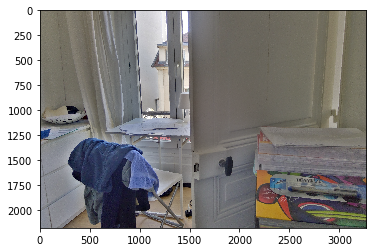

percentage of pixels out of bound: 0.008477058102652826
percentage of pixels out of bound: 0.0


In [4]:
product = pyramid_merge_low_ram(pictures_dir, setup, wc=wc, we=we, ws=ws, sigma=sigma, n=n)
print(np.max(product))
print(np.min(product))
plt.imshow(np.clip(product, 0, 255).astype("uint8"))
plt.show()

print("percentage of pixels out of bound:", percentage_outofbound(product))

result = np.clip(product, 0, 255)

print("percentage of pixels out of bound:", percentage_outofbound(result))

result = result.astype("uint8")
result = Image.fromarray(result, 'RGB')
result_name = setup + "_"
result_name += "n="+str(n)
result_name += "sigma="+str(sigma)
result_name += "we="+str(we)
result_name += "wc="+str(wc)
result_name += "ws="+str(ws)

results_dir = "results"
if not os.path.exists(os.path.join(results_dir, setup)):
    os.mkdir(os.path.join(results_dir, setup))

result.save(os.path.join(results_dir, setup, result_name + ".jpg"))